In [2]:
import numpy as np
np.seterr(invalid='ignore', divide='ignore')
from matplotlib import pyplot as plt
from matplotlib import colors

from numpy.random import rand
from scipy.stats import truncexpon

In [3]:
SMALL_SIZE = 20
MEDIUM_SIZE = 20
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
#######################################################################################################
########################################## USEFULL FUNCTIONS ##########################################
#######################################################################################################

### k-E relations ###
k2E = lambda k:81.8*(k/(2*np.pi))**2
E2k = lambda E:2*np.pi*np.sqrt(E/81.8)

### Q-theta relations ###
theta2Q = lambda omega, ki, theta: ki * np.sqrt(2 - omega/k2E(ki) - 2*np.sqrt(1 - omega/k2E(ki))*np.cos(theta))
Q2theta = lambda omega, ki, Q: np.arccos((2-Q**2/ki**2-omega/k2E(ki)) / (2*np.sqrt(1-omega/k2E(ki))))

##### dQ-dtheta relation #####
def dqdtheta(omega, ki, theta):
    a = 2-omega/k2E(ki)
    b = 2*np.sqrt(1-omega/k2E(ki))
    return ki**2/2 * b*np.sin(theta) / np.sqrt(a-b*np.cos(theta))

def dthetadq(omega, ki, Q):
    a = ki**2*(2-omega/k2E(ki))
    b = 2*ki**2*np.sqrt(1-omega/k2E(ki))
    return 2*Q/(b*np.sqrt(1-(a-Q**2)**2/b**2))



########################################################################################################
####################################### LINE-SOLID INTERCEPTIONS #######################################
########################################################################################################

############### Line parametrization ###############
def line_param(t, p, v):
    v = v/np.linalg.norm(v, axis=1)[:,None]
    return np.array([p[:,0] + v[:,0]*t, p[:,1] + v[:,1]*t, p[:,2] + v[:,2]*t]).T


############### CYLINDER ###############

### Line-cylinder intersection with p0 outside ###
# The interception is guaranteed by the given p and v, and happens on the cylinder and not on the plain boundaries. That is, whatch out for random p, v
def CylLine_inter_fromout(geom, p, v):
    # the incoming neutrons are aligned along x, therefor can hit only the vertical walls!
    r, h = geom[1:]
    v = v/np.linalg.norm(v, axis=1)[:,None]
  
    a = v[:,0]**2 + v[:,1]**2
    b = 2*(p[:,0]*v[:,0] + p[:,1]*v[:,1])
    c = p[:,0]**2 + p[:,1]**2 - r**2
    delta = b**2 - 4*a*c

    t1c, t2c = (-b + np.sqrt(delta))/(2*a), (-b - np.sqrt(delta))/(2*a)

    return np.sort((t1c, t2c), axis=0).T

### Line-cylinder intersection with p0 inside ###
# Only one foreword intercept is guaranteed, p is for shure inside the body
def CylLine_inter_fromin(geom, p, v):
    r, h = geom[1:]
    v = v/np.linalg.norm(v, axis=1)[:,None]

    ### cylinder
    a = v[:,0]**2 + v[:,1]**2
    b = 2*(p[:,0]*v[:,0] + p[:,1]*v[:,1])
    c = p[:,0]**2 + p[:,1]**2 - r**2
    delta = b**2 - 4*a*c

    tc = np.max([(-b + np.sqrt(delta))/(2*a), (-b - np.sqrt(delta))/(2*a)], axis=0) # take the higher t, that is the only one positive solution!

    ### planes
    tz = np.max([(h/2 - p[:,2])/v[:,2], (-h/2 - p[:,2])/v[:,2]], axis=0) # take the higher t, that is the only one positive solution!
    
    return np.sort((tc, tz), axis=0)[0].T


############### CUBOID ###############

### Line-cuboid intersection with p0 outside ###
def CubLine_inter_fromout(geom, p, v):
    # the incoming neutrons are aligned along x, therefor can hit only the x walls!
    dx, dy, dz = geom[1:]
    v = v/np.linalg.norm(v, axis=1)[:,None]
  
    # intercepts
    t1x, t2x = (-dx/2 - p[:,0])/v[:,0], (+dx/2 - p[:,0])/v[:,0]

    return np.sort([t1x, t2x])[:2].T

### Line-cuboid intersection with p0 inside ###
def CubLine_inter_fromin(geom, p, v):
    dx, dy, dz = geom[1:]
    v = v/np.linalg.norm(v, axis=1)[:,None]

    # intercepts
    tx = np.max([(-dx/2 - p[:,0])/v[:,0], (+dx/2 - p[:,0])/v[:,0]], axis=0)
    ty = np.max([(-dy/2 - p[:,1])/v[:,1], (+dy/2 - p[:,1])/v[:,1]], axis=0)
    tz = np.max([(-dz/2 - p[:,2])/v[:,2], (+dz/2 - p[:,2])/v[:,2]], axis=0)
    
    return np.min((tx, ty, tz), axis=0).T


############### ANULAR ###############

### Line-anular intersection with p0 outside ###
# The interception is guaranteed by the given p and v, and happens on the cylinder and not on the plain boundaries. That is, whatch out for random p, v
def AnuLine_inter_fromout(geom, p, v):
    r1, r2, h = geom[1:]
    v = v/np.linalg.norm(v, axis=1)[:,None]

    # the incoming neutrons are aligned along x, therefor can hit only the vertical walls!
    a = v[:,0]**2 + v[:,1]**2
    b = 2*(p[:,0]*v[:,0] + p[:,1]*v[:,1])

    c2 = p[:,0]**2 + p[:,1]**2 - r2**2
    delta2 = b**2 - 4*a*c2

    c1 = p[:,0]**2 + p[:,1]**2 - r1**2
    delta1 = b**2 - 4*a*c1

    t1c, t2c, t3c, t4c = (-b + np.sqrt(delta2))/(2*a), (-b - np.sqrt(delta2))/(2*a), (-b + np.sqrt(delta1))/(2*a), (-b - np.sqrt(delta1))/(2*a)
    # if no 4 intercepts, wh have nans!
    return np.sort((t1c, t2c, t3c, t4c), axis=0).T

### Line-anular intersection with p0 inside ###
# Only one foreword intercept is guaranteed, p is for shure inside the body
def AnuLine_inter_fromin(geom, p, v):
    r1, r2, h = geom[1:]
    v = v/np.linalg.norm(v, axis=1)[:,None]

    ### cylinders
    a = v[:,0]**2 + v[:,1]**2
    b = 2*(p[:,0]*v[:,0] + p[:,1]*v[:,1])

    c2= p[:,0]**2 + p[:,1]**2 - r2**2
    delta2 = b**2 - 4*a*c2

    c1 = p[:,0]**2 + p[:,1]**2 - r1**2
    delta1 = b**2 - 4*a*c1

    tc1 = np.max([(-b + np.sqrt(delta2))/(2*a), (-b - np.sqrt(delta2))/(2*a)], axis=0) # the external cylinder can have only one intercept!
    pc1 = line_param(tc1, p, v)
    tc1[(pc1[:,2]>h/2)|(pc1[:,2]<-h/2)] = np.nan  #check if it have!
    
    tc2, tc3 = (-b + np.sqrt(delta1))/(2*a), (-b - np.sqrt(delta1))/(2*a) # this can have 0, 1 or 2 intercept
    tc2[tc2<0] = np.nan # should be foreword
    tc3[tc3<0] = np.nan

    pc2 = line_param(tc2, p, v)
    tc2[(pc2[:,2]>h/2)|(pc2[:,2]<-h/2)] = np.nan # and should hapend in +-h/2
    pc3 = line_param(tc3, p, v)
    tc3[(pc3[:,2]>h/2)|(pc3[:,2]<-h/2)] = np.nan

    ### planes
    tz = np.max([(h/2 - p[:,2])/v[:,2], (-h/2 - p[:,2])/v[:,2]], axis=0)
    pz = line_param(tz, p, v)
    tz[((pz[:,0]**2 + pz[:,1]**2) < r1**2)|((pz[:,0]**2 + pz[:,1]**2) > r2**2)] = np.nan
    
    return  np.sort((tc1, tc2, tc3, tz), axis=0)[:3].T # in total, a maximum three intercepts|


########################################################################################################
########################################## NEUTRON GENERATION ##########################################
########################################################################################################

def ngen4Cyl(geom, x_init, N):
    r, h = geom[1:]
    return np.array([[x_init]*N, rand(N) * 2*r - r, rand(N) * h - h/2]).T

def ngen4Cub(geom, x_init, N):
    dx, dy, dz = geom[1:]
    return np.array([[x_init]*N, rand(N) * dy - dy/2, rand(N) * dz - dz/2]).T

def ngen4Anu(geom, x_init, N):
    r1, r2, h = geom[1:]
    return np.array([[x_init]*N, rand(N) * 2*r2 - r2, rand(N) * h - h/2]).T

# Monte carlo simulation of inelastic multiple scattering

# Variables for simulation

## Geometry
The experimental geometry, i.e. the sample shape (within the cell): could be a cylinder, a cuboid or an anular cll.)

In [5]:
#####################
###### Geometry #####
#####################
geom = ('cylinder', 1.2, 3) # r, h
#geom = ('cuboid', .1, 10, 10) # dx, dy, dz
#geom = ('anular', 1.0, 1.2, 2) # r1, r2, h

### Experiment geometry ###
x_init = -100 #cm

### "detector" apertures
dOmega_det = 4*np.pi/10000
domega_det = .01

In [6]:
if geom[0]=='cuboid':
    geom_type = 'convex'
    ngen = lambda N: ngen4Cub(geom, x_init, N)
    inter_fromout, inter_fromin = lambda p, v: CubLine_inter_fromout(geom, p, v), lambda p, v: CubLine_inter_fromin (geom, p, v)
elif geom[0]=='cylinder':
    geom_type = 'convex'
    ngen = lambda N: ngen4Cyl(geom, x_init, N)
    inter_fromout, inter_fromin = lambda p, v: CylLine_inter_fromout(geom, p, v), lambda p, v: CylLine_inter_fromin (geom, p, v)
elif geom[0]=='anular':
    geom_type = 'concave'
    ngen = lambda N: ngen4Anu(geom, x_init, N)
    inter_fromout, inter_fromin = lambda p, v: AnuLine_inter_fromout(geom, p, v), lambda p, v: AnuLine_inter_fromin (geom, p, v)

## Scattering geometry
Here we define the scattering geometry: the initial and final energy of the neutron, and the scattering angle.

In [7]:
####################################
##### Scattering configuration #####
####################################

### Incident energy ###
ki = 6.4 #A^-1

### Final energy ###
kf = 4.9 #A^-1

### Scattering angle###
theta = np.deg2rad(1)

### Othr parameters ###
Ei = k2E(ki) #meV
Ef = k2E(kf)
omega = Ei - Ef
Q = theta2Q(omega, ki, theta)

In [8]:
print('ki = ', ki, 'A^-1')
print('kf = ', kf, 'A^-1')
print('theta = ', np.rad2deg(theta), 'deg')
print('Ei = ', Ei, 'meV')
print('Ef = ', Ef, 'meV')

print('omega = ', omega, 'meV')
print('Q = ', Q, 'A^-1')

ki =  6.4 A^-1
kf =  4.9 A^-1
theta =  1.0 deg
Ei =  84.86986569669868 meV
Ef =  49.74915711371425 meV
omega =  35.120708582984435 meV
Q =  1.5031808140709941 A^-1


## Scattering lenghts

In [9]:
##############################
##### Scattering lenghts #####
##############################
mu_s = .1 #cm^-1
mu_abs = 0.0 #cm^-1
mu_tot = mu_s + mu_abs

## S(Q, $\omega$)
In the simulation, the $S(Q,\omega)$ is saved as a evenly spaced in Q and $\omega$ matrix (also referred to as mesh):
$$
S_{i,j} = S(Q_i, \omega_j)
$$
with $Q_i$ a 1D vector evenly spaced at $dQ_{vec}$, and $\omega_j$ a 1D vector evenly spaced at $d\omega_{vec}$:
$$
Q_{i} \hspace{.3cm} i = 1, \ldots, N_{Q} \hspace{.5cm} \text{and} \hspace{.5cm} \omega_{i} \hspace{.3cm} i = 1, \ldots, N_{\omega}   
$$
This, once loaded on the RAM, allows faster computations with respect to an
analytical expression. Moreover, it allows both the use of analytical functions (they can always be discretized) as well experimental data, or mixed version of these.


In [10]:
##################
##### S(Q,w) #####
##################
# 0: Vanadium -> S(Q,w) = exp(-omega^2/2sigma^2), sigma small
# 1: D-glycerol -> S(Q,w) is inelastic

##################
S_number = 1
##################

if S_number==0:
    Sij = np.load('./data_Sq/Sqw_vanadium/S_mesh.npy')
    Qi = np.load('./data_Sq/Sqw_vanadium/Q_vec.npy')
    omegaj = np.load('./data_Sq/Sqw_vanadium/omega_vec.npy')
elif S_number==1:
    Sij = np.load('./data_Sq/Sqw_d-glycerol/S_mesh.npy')
    Qi = np.load('./data_Sq/Sqw_d-glycerol/Q_vec.npy')
    omegaj = np.load('./data_Sq/Sqw_d-glycerol/omega_vec.npy')

In [11]:
# USEFULL VECTORS
dQi = Qi[1]-Qi[0]
domegaj = omegaj[1]-omegaj[0]
Qij, omegaij = np.meshgrid(Qi, omegaj)
Qij, omegaij = Qij.T, omegaij.T

In [12]:
# Useful object for plots
S_imshow_extent = [omegaj.min(),omegaj.max(),Qi.max(),Qi.min()]

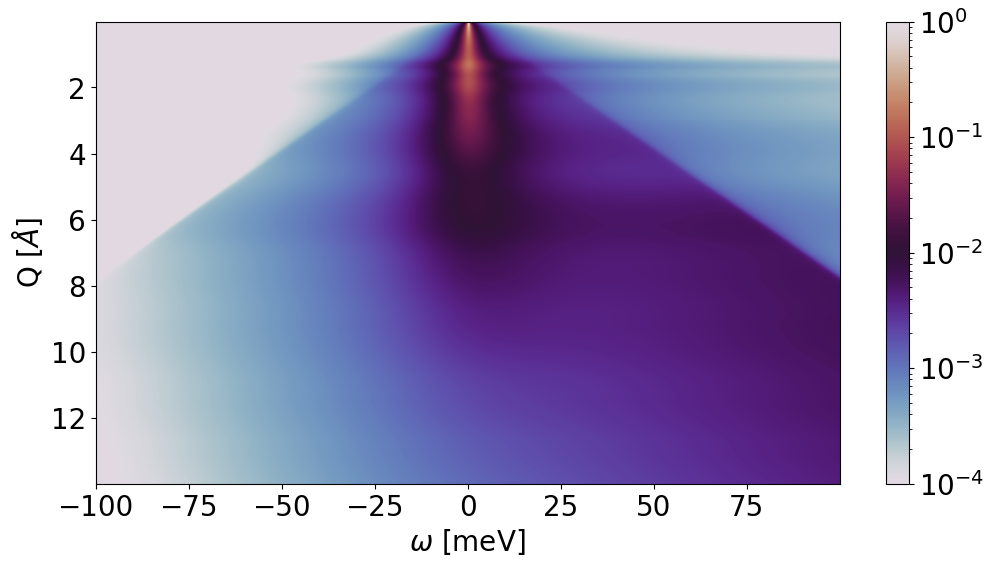

In [13]:
# plot
plt.figure(figsize=(12,6))
#plt.title('Loaded $S_{i,j}$')
plt.imshow(Sij, norm='log', cmap='twilight', aspect='auto', extent=S_imshow_extent, vmin=1e-4, vmax=1e0)
plt.xlabel('$\omega$ [meV]')
plt.ylabel('Q [$\AA$]')
plt.colorbar()
#plt.ylim(0,5)
#plt.xlim(-50,50)

plt.savefig('./figures4article/Sij.png')

# Initial calculations
In this section we present the initial calculus needed for the simulation.

## Dynamc range for direct scattering event
The $\theta$-Q relations are:

$$
Q = k_i \sqrt{2 - \frac{\omega}{E_i} - 2\sqrt{1 - \frac{\omega}{E_i}} \cos(\theta)}
\hspace{1cm} \cos(\theta) = \frac{k_i^2\left(2 - \frac{\omega}{E_i}\right) - Q^2}{2k_i^2 \sqrt{1 - \frac{\omega}{E_i}}}
$$
And these relations gives the kinematic range accessible by a neutron with an initial energy $E_i$:
$$
\begin{split}
    Q_{\text{lowlim}} (k_i, \omega) &= k_i \sqrt{2 - \frac{\omega}{E_i} - 2\sqrt{1 - \frac{\omega}{E_i}}} \\
    Q_{\text{uplim}}  (k_i, \omega) &= k_i \sqrt{2 - \frac{\omega}{E_i} + 2\sqrt{1 - \frac{\omega}{E_i}}}
\end{split}
$$
Rewritten in python functions these relations are:

<code>theta2Q = lambda omega, ki, theta: ki * np.sqrt(2 - omega/k2E(ki) - 2*np.sqrt(1 - omega/k2E(ki))*np.cos(theta))</code>

<code>Q2theta = lambda omega, ki, Q: np.arccos((2-Q**2/ki**2-omega/k2E(ki)) / (2*np.sqrt(1-omega/k2E(ki))))</code>

Example of Q-theta relation for $\omega$ = 10 meV


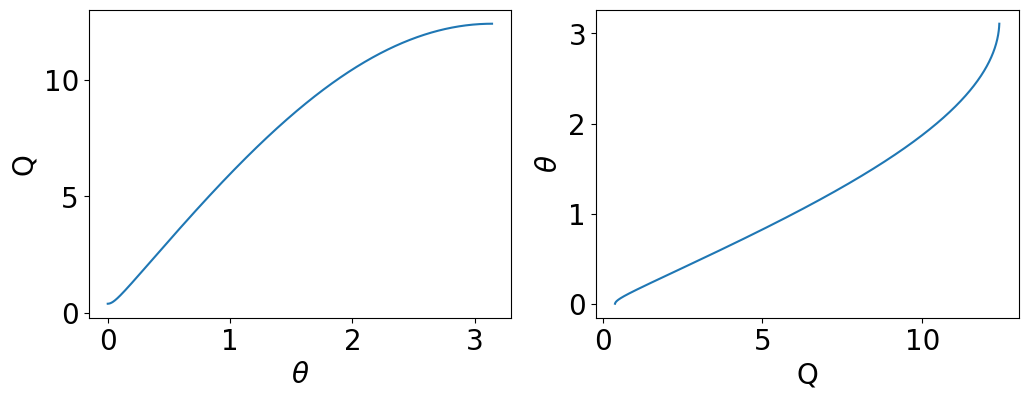

In [14]:
# plot
OMEGA = 10

X = np.linspace(0, np.pi, 1000)
Y = theta2Q(OMEGA, ki, X)

plt.figure(figsize=(12,4))
print('Example of Q-theta relation for $\omega$ = %s meV' % OMEGA)
plt.subplot(1,2,1)
plt.plot(X,Y)
plt.xlabel(r'$\theta$')
plt.ylabel('Q')

X = np.linspace(0, 20, 10000)
Y = Q2theta(OMEGA, ki, X)

plt.subplot(1,2,2)
plt.plot(X,Y)
plt.ylabel(r'$\theta$')
plt.xlabel('Q');

In [15]:
###############################################
##### Dynamic range for direct scattering #####
###############################################
Qlowlimi = lambda ki: ki * np.sqrt(2 - omegaj/k2E(ki) - 2*np.sqrt(1 - omegaj/k2E(ki)))
Quplimi  = lambda ki: ki * np.sqrt(2 - omegaj/k2E(ki) + 2*np.sqrt(1 - omegaj/k2E(ki)))

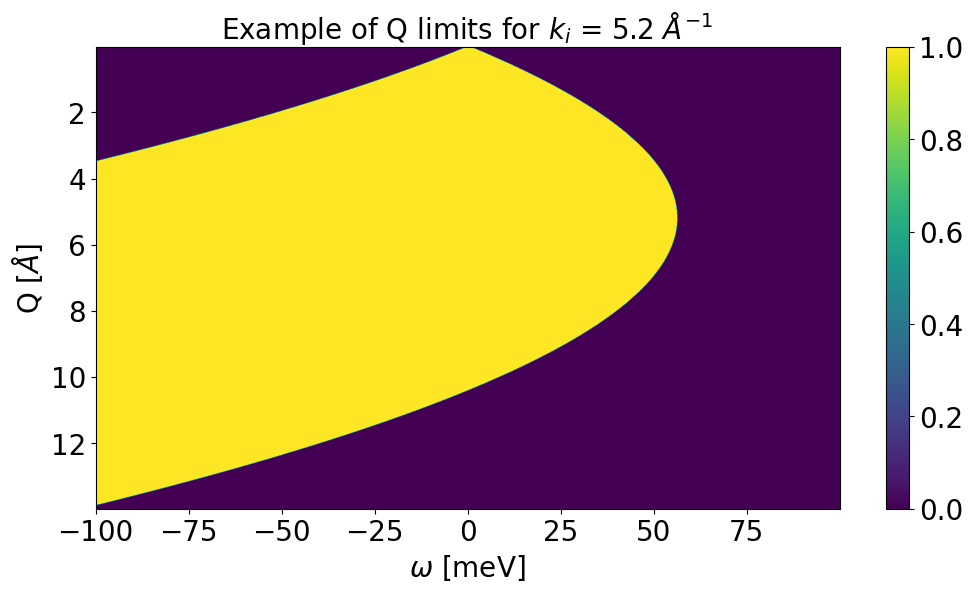

In [16]:
# usage example
k = 5.2 # chose the k value
out = (Qij>Qlowlimi(k)) & (Qij<Quplimi(k))

# plot
plt.figure(figsize=(12,6))
plt.title('Example of Q limits for $k_i$ = %s $\AA^{-1}$' % k)
plt.imshow(out, aspect='auto', extent=S_imshow_extent)
plt.xlabel('$\omega$ [meV]')
plt.ylabel('Q [$\AA$]')
plt.colorbar();

## $d\theta$-dQ relation
A foundamental relation is the derivative of $\theta$ with respect to $Q$, needed t account the fact that the scattering probability $S(Q, \omega)$ is not evenly spaced in $\theta$ (it would be impossble) but in $Q$. The relation is:
$$
\cos(\theta) = \frac{k_i^2\left(2-\frac{\omega}{E_i}\right) - Q^2}{2k_i^2 \sqrt{1 - \frac{\omega}{E_i}}} = \frac{a - Q^2}{b}
$$
where
$$
a = k_i^2\left(2 - \frac{\omega}{E_i}\right), \hspace{2cm} b = 2k_i^2\sqrt{1 - \frac{\omega}{E_i}}
$$
$$
\Rightarrow \frac{d\theta}{dQ} = \frac{2Q}{b \sqrt{1 - \left(\frac{a - Q^2}{b}\right)^2}}
$$

<code>def dthetadq(omega, ki, Q):<br>
&nbsp;&nbsp;&nbsp;&nbsp; a = ki^2 *(2-omega/k2E(ki))<br>
&nbsp;&nbsp;&nbsp;&nbsp; b = 2*ki^2 *np.sqrt(1-omega/k2E(ki))<br>
&nbsp;&nbsp;&nbsp;&nbsp; return 2*Q/(b*np.sqrt(1-(a-Q**2)**2/b**2)) </code>

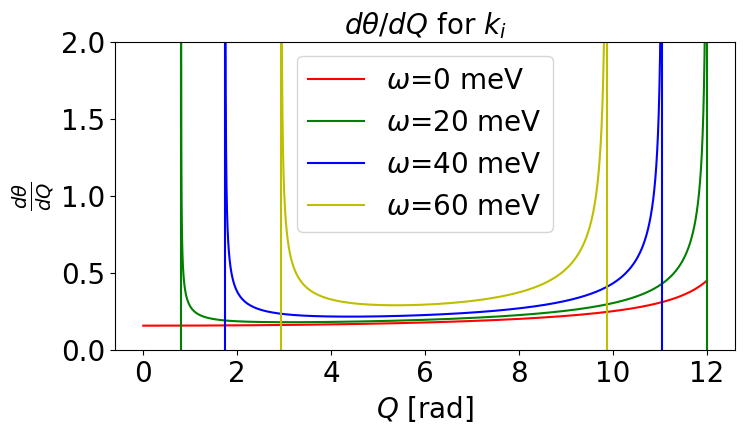

In [17]:
# plot
X = np.linspace(0, 12, 10000)

plt.figure(figsize=(8,4))
plt.title(r'$d\theta /dQ$ for $k_i$')
plt.plot(X, dthetadq(0, ki, X), label='$\omega$=0 meV', c='r')
plt.plot(X, dthetadq(20, ki, X), label='$\omega$=20 meV', c='g')
plt.axvline(theta2Q(20, ki, 0), c='g')
plt.axvline(theta2Q(20, ki, np.pi), c='g')
plt.plot(X, dthetadq(40, ki, X), label='$\omega$=40 meV', c='b')
plt.axvline(theta2Q(40, ki, 0), c='b')
plt.axvline(theta2Q(40, ki, np.pi), c='b')
plt.plot(X, dthetadq(60, ki, X), label='$\omega$=60 meV', c='y')
plt.axvline(theta2Q(60, ki, 0), c='y')
plt.axvline(theta2Q(60, ki, np.pi), c='y')

plt.ylim(0,2)

plt.xlabel(r'$Q$ [rad]')
plt.ylabel(r'$\frac{d\theta}{dQ}$')
plt.legend();

## Lamber-Beer law

In [18]:
###########################
##### Lamber-Beer law #####
###########################

# Trasmission
T_tot = lambda d: np.exp(-mu_tot*d)

# Random scattering extraction from Lamber-Beer law
rand_LB = lambda b: truncexpon.rvs(b = b*mu_tot)/mu_tot

# The simulation
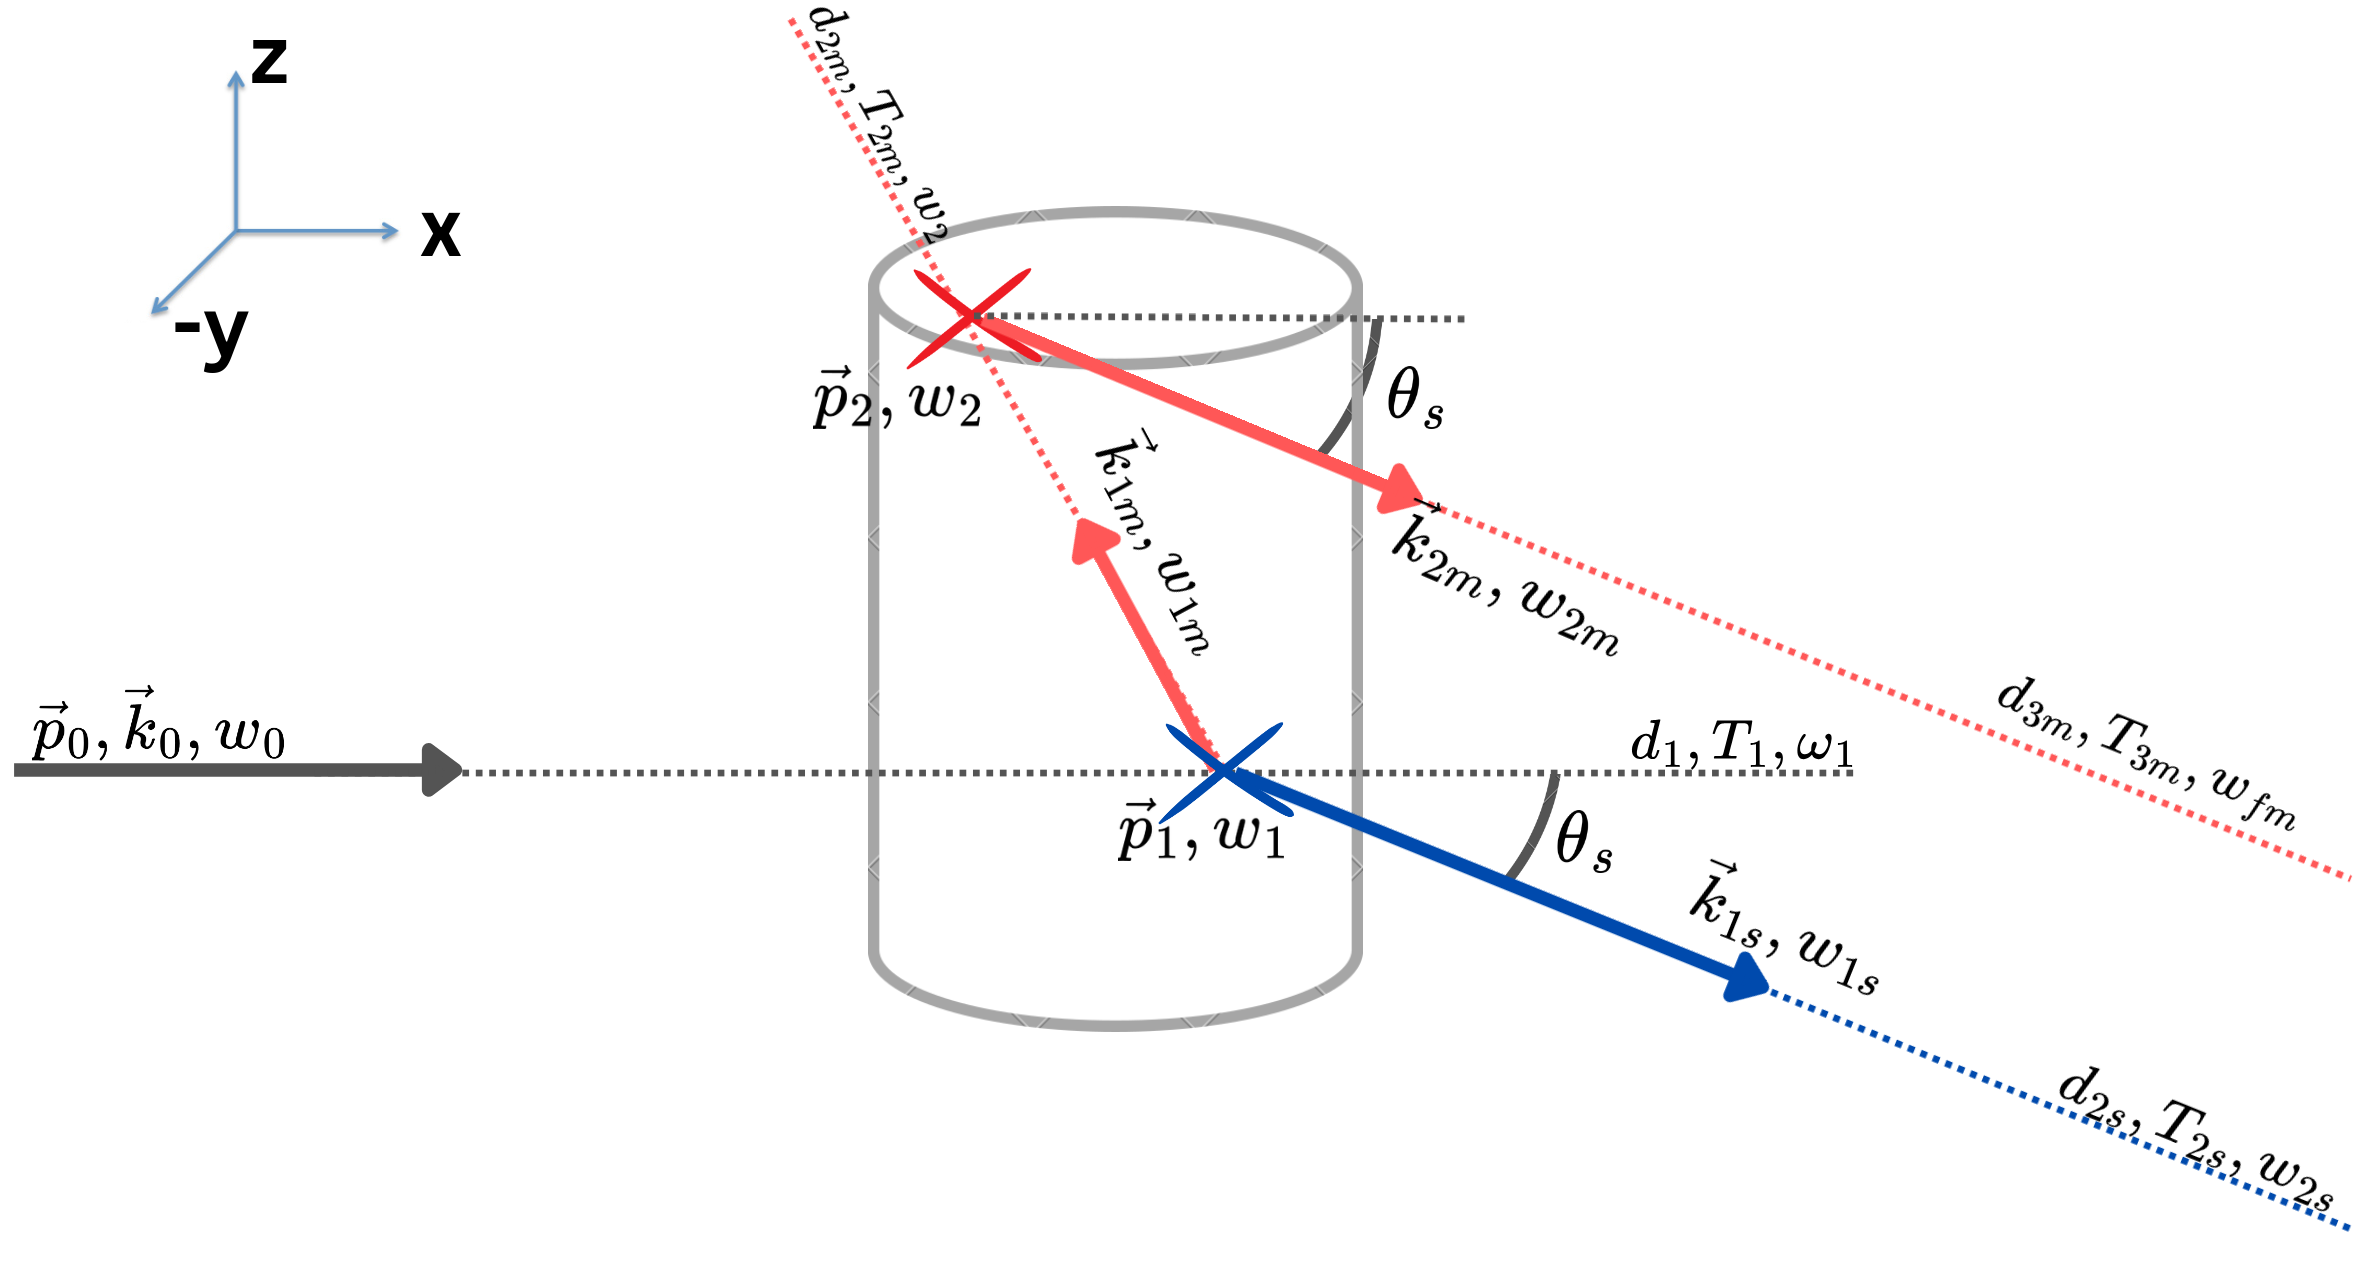

In [19]:
###############################
##### # of Montecrlo reps #####
###############################
N=10000000
B = 40

## Initial coordinates
$$
\textbf{p}_0 = (x_0, \ \text{rand } y_0, \ \text{rand } z_0) \hspace{1cm}    \textbf{k}_0 = (k_i, 0, 0) \hspace{1cm} \omega_0=1
$$

In [20]:
##########################
##### THE SIMULATION #####
##########################

##### RANDOMLY GENERATE N NEUTRONS #####
# from uniform beam at x=-x_init, random z = [-h/2, h/2] and y[-r, r]
p0 = ngen(N)
k0 = np.array([[ki, 0, 0]]*N)
w0 = np.array([1]*N)

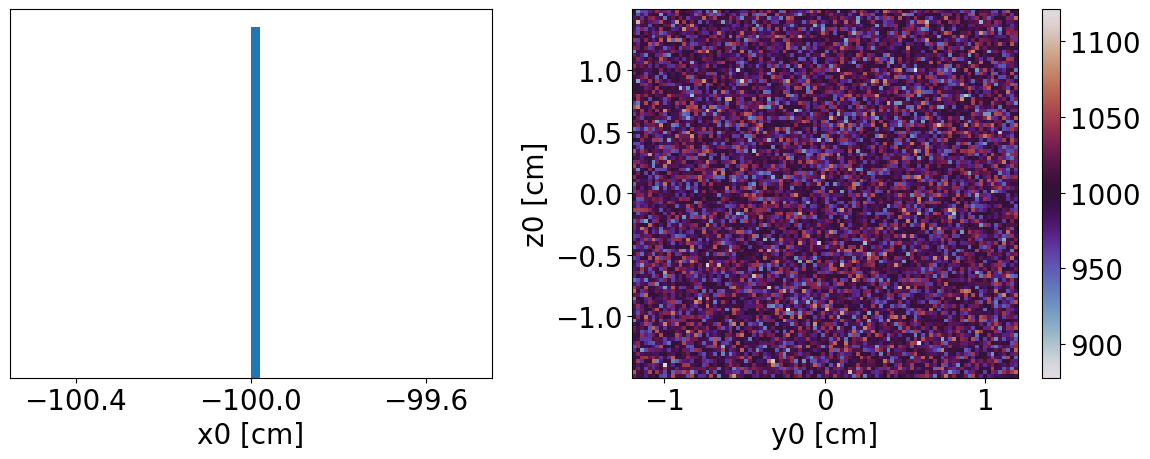

In [21]:
# plots
plt.figure(figsize=(12,5))
#plt.title('Starting point p0 of the neutrons');
plt.subplot(1,2,1)
plt.hist(p0[:,0], bins=50)
plt.xlabel('x0 [cm]')
plt.yticks([])
plt.xticks([-100.4, -100, -99.6])
plt.subplot(1,2,2)
plt.hist2d(p0[:,1], p0[:,2], bins=100, cmap='twilight')
plt.xlabel('y0 [cm]')
plt.ylabel('z0 [cm]');
plt.colorbar()
plt.tight_layout()

plt.savefig('./figures4article/p0.png')

In [22]:
# dimensions of the vectors
print('p0:', p0.nbytes/1e6, 'MB')
print('k0:', k0.nbytes/1e6, 'MB')
print('w0:', w0.nbytes/1e6, 'MB')

p0: 240.0 MB
k0: 240.0 MB
w0: 80.0 MB


## First scattering position
Weight update:
$$ w_1 = w_0 (1-T(d_1)) \frac{\mu_s}{\mu_{tot}} $$
And extraction from a truncated exponential:
$$ PDF_{L-B\  trunc} = e^{-\mu_{s}x} \hspace{1cm} \text{with} \hspace{1cm} x = [0,d_1] $$
N.B. : Care must be taken in the case of non convex sample geometries, where voids must be taken into account!

The output of this subsection is therefor
$$ \vec{p_1} \hspace{1cm} \text{and} \hspace{1cm} w_1

In [23]:
##### EXTRACT THE 1ST SCATTERING POSITION #####

# intercept calculation
ts = inter_fromout(p0, k0)
ts = np.nan_to_num(ts)
if geom_type=='convex':
    ts = np.append(ts, np.zeros((N,2)), axis=1)
if geom_type=='concave':
    pass
d1 = (ts[:,1] - ts[:,0]) + (ts[:,3] - ts[:,2])
# weigth update
w1 = w0*(1-T_tot(d1))*(mu_s/mu_tot)
# dtp2 extraction (one for all)
dtp2 = rand_LB(d1)
# generate void vector
void = np.where(dtp2<=(ts[:, 1]-ts[:, 0]), 0, ts[:,2] - ts[:,1])

p1 = line_param(ts[:,0] + dtp2 + void, p0, k0)

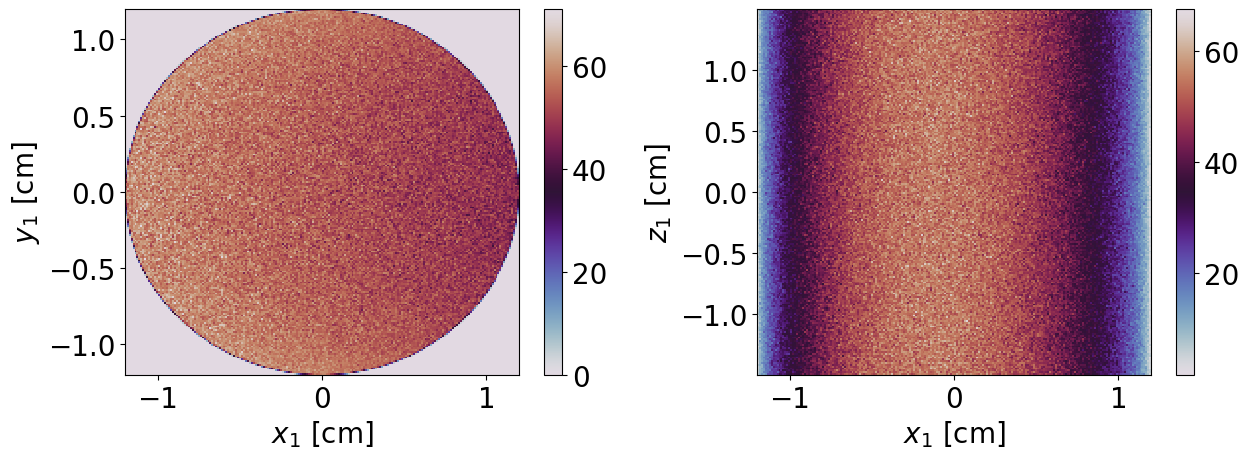

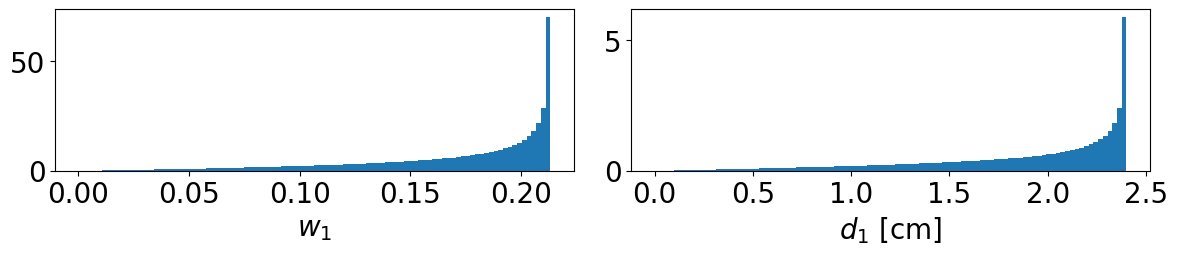

In [24]:
# plots

# heatmap
plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.hist2d(p1[:,0], p1[:,1], bins=200, weights=w1, cmap='twilight');
X = np.linspace(0, p1[:,0].max(), 100)
#plt.plot(X, X*np.sin(theta), c='r')
#plt.plot(X, X*np.sin(0), c='r')
plt.xlabel(r'$x_1$ [cm]')
plt.ylabel(r'$y_1$ [cm]')
plt.colorbar()
plt.subplot(1,2,2)
plt.hist2d(p1[:,0], p1[:,2], bins=200, weights=w1, cmap='twilight');
plt.xlabel(r'$x_1$ [cm]')
plt.ylabel(r'$z_1$ [cm]')
plt.tight_layout()
plt.colorbar()

plt.savefig('./figures4article/p1.png')

# 2D
plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
plt.hist(w1, bins=100, density=True);
plt.xlabel(r'$w_1$')
plt.subplot(1,2,2)
plt.hist(d1, bins=100, density=True);
plt.xlabel(r'$d_1$ [cm]')
plt.tight_layout()

## Single scattering path

$$ k_{1s} = k_f * (cos(\theta), sin(\theta), 0) $$
$$ \omega_{1s} = E_i - E_f $$
$$ Q_{1s} = |k_i - k_f|$$
$$ \theta_{1s} = \theta_s

In [25]:
####################################
###### SINGLE SCATTERING PATH ######
####################################

### PROBABILITY OF SINGLE SCATTERING ###
k1s = kf * np.array([np.cos(theta), np.sin(theta), 0]) * np.ones((N, 3))
Q1s = np.linalg.norm(k0 - k1s, axis=1)
omega1s = (Ei - Ef) * np.ones(N)

$$
S^{k_i}_{i,j} =
\left\{ 
    \begin{array}{l}
        S_{i,j} \hspace{.5cm} \text{if} \hspace{.5cm} Q_{lowlim}(k_i,\omega_j) \leq Q_i \leq Q_{uplim}(k_i,\omega_j), \\
        0 \hspace{.5cm} \text{otherwise}
    \end{array} 
\right.
$$

In [26]:
##### Cut of the S(Q,w) for Ei #####
Mij_ki = (Qij>Qlowlimi(ki)) & (Qij<Quplimi(ki)) # mask for ki
Sij_ki = Mij_ki * Sij

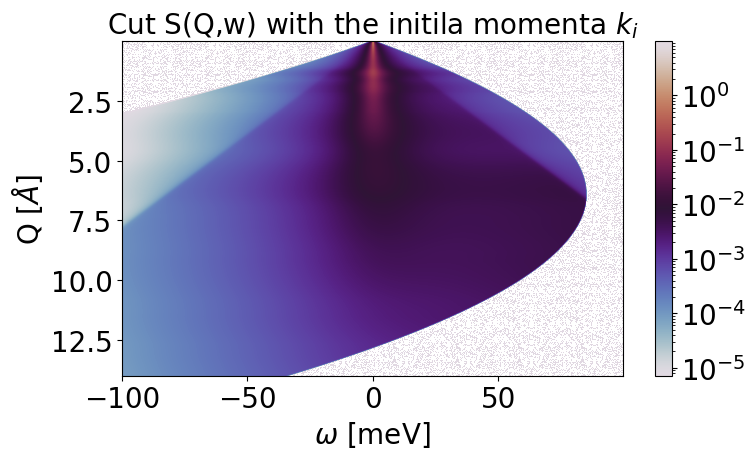

In [27]:
# plot
plt.figure(figsize=(8,5))
plt.title('Cut S(Q,w) with the initila momenta $k_i$')
plt.imshow(Sij_ki, aspect='auto', norm='log', extent=S_imshow_extent, cmap='twilight')
plt.xlabel('$\omega$ [meV]')
plt.ylabel('Q [$\AA$]')
plt.colorbar();
plt.tight_layout()

$$
d\theta_{i,j} = \frac{d\theta}{dQ}(Q_{i},\omega_{j}) dQ_{vec}
$$

In [28]:
##### dthetadQ on the mesh #####
dthetadqij_ki = np.nan_to_num(dthetadq(omegaij, ki, Qij))
dthetadqij_ki[dthetadqij_ki>1e10] = 0

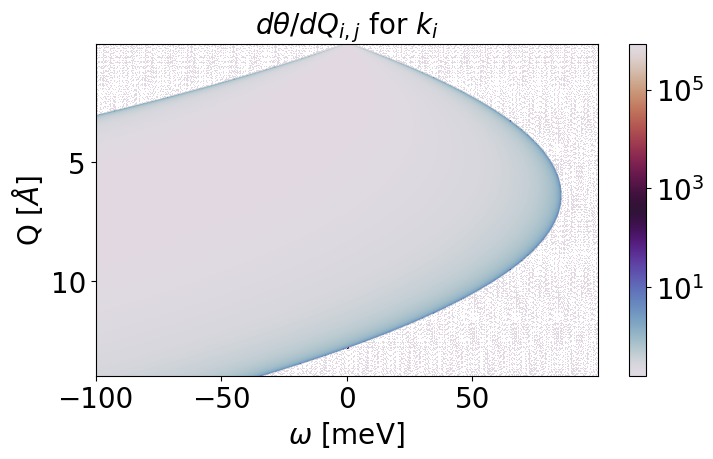

In [29]:
# plot
plt.figure(figsize=(8,5))
plt.title(r'$d\theta /dQ_{i,j}$ for $k_i$')
plt.imshow(dthetadqij_ki, aspect='auto', extent=S_imshow_extent, norm='log', cmap='twilight')
plt.xlabel('$\omega$ [meV]')
plt.ylabel('Q [$\AA$]')
plt.colorbar()
plt.tight_layout()

$$
    P^{k_i}(\theta , \phi , \omega) =  \frac{\sqrt{1-\frac{\omega_j}{E_i}}S^{k_i}_{i,j}}{\text{norm}} d\omega d\Omega_{det} 
$$
with
$$
\text{norm} \simeq 2\pi \sum_i^{N_Q} \sum_j^{N_\omega} \sqrt{1-\frac{\omega_j}{E_i}} S^{k_i}_{i,j} d\omega_j (\frac{d\theta}{dQ})^{k_i}_{i,j} dQ_i \sin\theta_{i,j}^{k_i}
$$

In [30]:
##### S(Q,w) normalization #####
sinthetaij_ki = np.nan_to_num(np.sin(Q2theta(omegaij, ki, Qij)))
norm = 2*np.pi* np.sum(np.nan_to_num(np.sqrt(1-omegaij/Ei)) *  Sij_ki * domegaj * dthetadqij_ki * dQi * sinthetaij_ki)

Pij_ki = np.nan_to_num(np.sqrt(1-omegaij/Ei)) * Sij_ki / norm * domega_det * dOmega_det

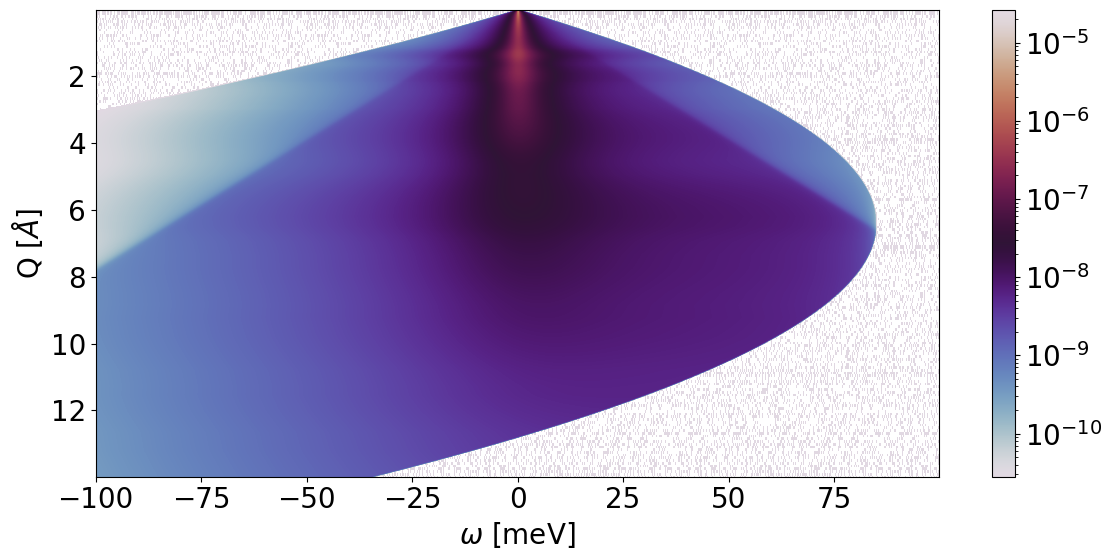

In [31]:
# plot
plt.figure(figsize=(12,6))
#plt.title(r'$P_{i,j}^{k_i}$')
plt.imshow(Pij_ki, aspect='auto', extent=S_imshow_extent, norm='log', cmap='twilight')
plt.xlabel('$\omega$ [meV]')
plt.ylabel('Q [$\AA$]')
plt.colorbar()
plt.tight_layout()

plt.savefig('./figures4article/Pij_ki.png')

Find $i,j$ and update the weights
$$
w_{1s} = w_1 P_{i,j}^{k_i}(\theta_s , \phi=0 , \omega_s)
$$

In [32]:
##### Get the scattering probavilities #####
Q_idx = np.searchsorted(Qi, Q1s)
omega_idx = np.searchsorted(omegaj, omega1s)

w1s = w1 * Pij_ki[Q_idx, omega_idx]

And
$$ w_{fs} = w_{1s} T(d_{2s})$$

In [33]:
##### 1s intercept calculation #####
ts = inter_fromin(p1, k1s)
ts = np.nan_to_num(ts)
if geom_type=='convex':
    ts = np.column_stack([ts, np.zeros((N,2))])
if geom_type=='concave':
    pass

d2s = ts[:,0] + (ts[:,2] - ts[:,1])

##### wfs weigth update #####
wfs = w1s*T_tot(d2s)

$$
I_s = \frac{1}{N} \sum_{i=1}^{N} w_{fs}
$$

In [34]:
##### Intensity #####
Is = wfs.mean()
print('Is = ', Is)

Is =  2.768741341746555e-10


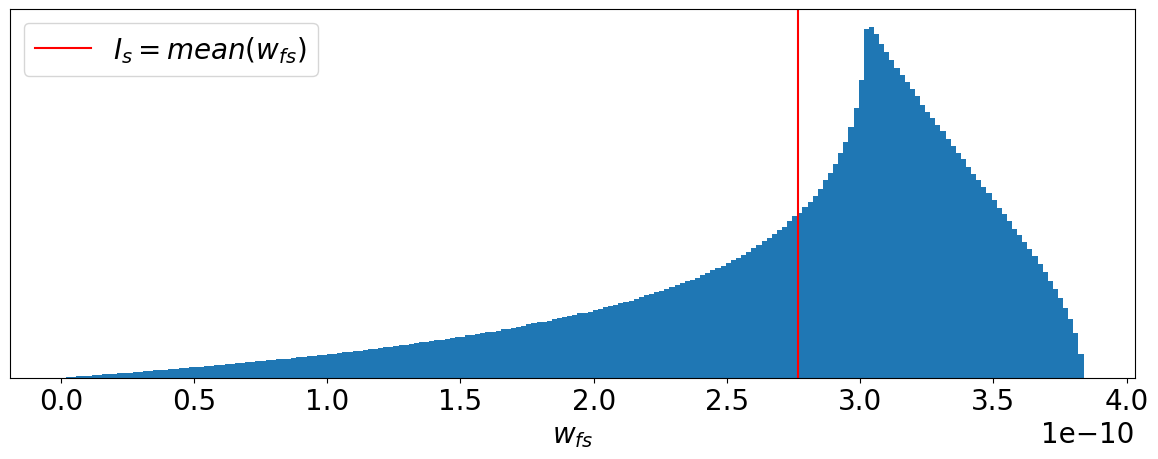

In [35]:
# plot
plt.figure(figsize=(12,5))
plt.hist(wfs, bins=200);
plt.yticks([])
plt.axvline(Is, c='r', label=r'$I_s = mean(w_{fs}$)')
plt.xlabel(r'$w_{fs}$')
plt.legend()
plt.tight_layout()

plt.savefig('./figures4article/wfs.png')

## Multiple scattering path

### Extraction of a scattering direction and energy
$$
W_{i,j}^{k_i} \propto \sqrt{1-\frac{\omega_j}{E_i}}S_{i,j}^{k_i} (\frac{d\theta}{dQ})_{i,j}^{k_i} \sin\theta_{i,j}^{k_i} \hspace{.5cm} \text{with} \hspace{.5cm} \sum_{i,j} W_{i,j} = 1
$$

In [36]:
####################################
##### MULTIPLE SCATTERING PATH #####
####################################

##### EXTRACTION FROM S(q,W) #####

# Probaility mesh for random choiches
Wij_ki = np.nan_to_num(np.sqrt(1-omegaij/Ei)) * Sij_ki * dthetadqij_ki * sinthetaij_ki
Wij_ki /= Wij_ki.sum()

# Random extractions
ij = np.random.choice(np.arange(Wij_ki.size), p=Wij_ki.reshape(-1), size=N)

# Extracted scattering variables
Q1m = Qij.reshape(-1)[ij]
omega1m = omegaij.reshape(-1)[ij]
theta1m = Q2theta(omega1m, ki, Q1m)
E1m = Ei - omega1m
w1m = w1

# Random angle on the scattering cone
phi1m = rand(N)*2*np.pi

# Neutrom momenta after scattering
k1m = (np.array((np.cos(theta1m), np.sin(theta1m)*np.cos(phi1m), np.sin(theta1m)*np.sin(phi1m))) * E2k(E1m)).T
k1m_mod = E2k(E1m)

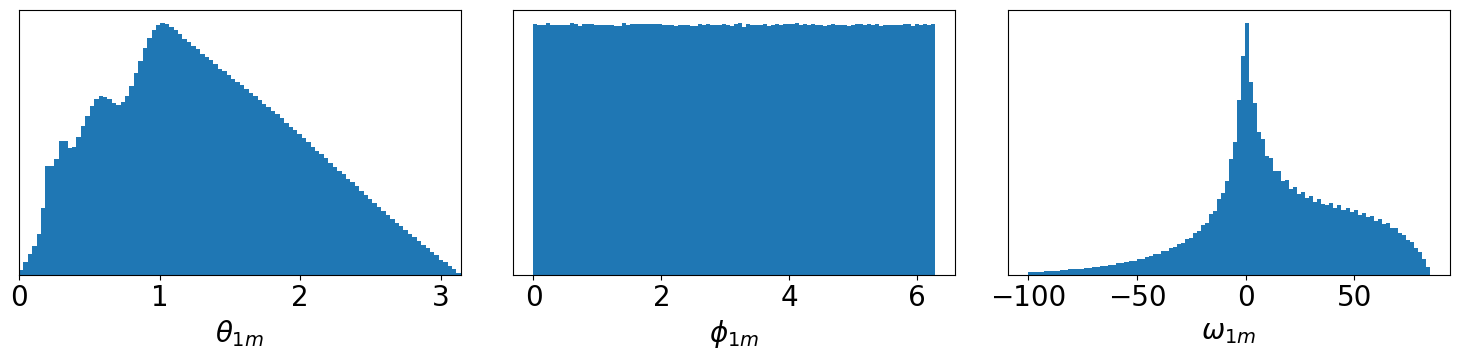

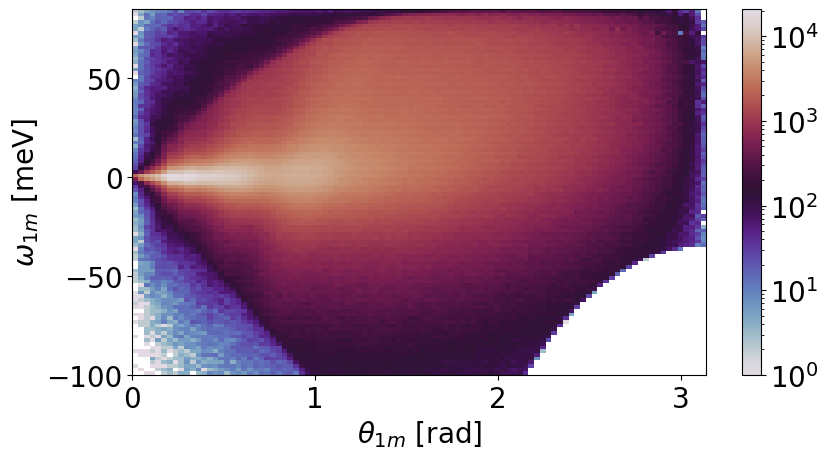

In [52]:
# plot
# 2D
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.hist(theta1m, bins=100, density=True);
plt.yticks([])
plt.xlabel(r'$\theta_{1m}$')
plt.xlim(0, np.pi)
plt.subplot(1,3,2)
plt.hist(phi1m, bins=100, density=True);
plt.yticks([])
plt.xlabel(r'$\phi_{1m}$')
plt.subplot(1,3,3)
plt.hist(omega1m, bins=100, density=True);
plt.yticks([])
plt.xlabel(r'$\omega_{1m}$')
plt.tight_layout()

plt.savefig('./figures4article/event_extraction.png')

# 3D
plt.figure(figsize=(9,5))
plt.hist2d(theta1m, omega1m, bins=100, norm='log', cmap='twilight');
plt.ylabel('$\omega_{1m}$ [meV]')
plt.xlabel(r'$\theta_{1m}$ [rad]')
plt.colorbar()
plt.xlim(0, np.pi)
plt.tight_layout()

plt.savefig('./figures4article/theta1m_omega1m.png')

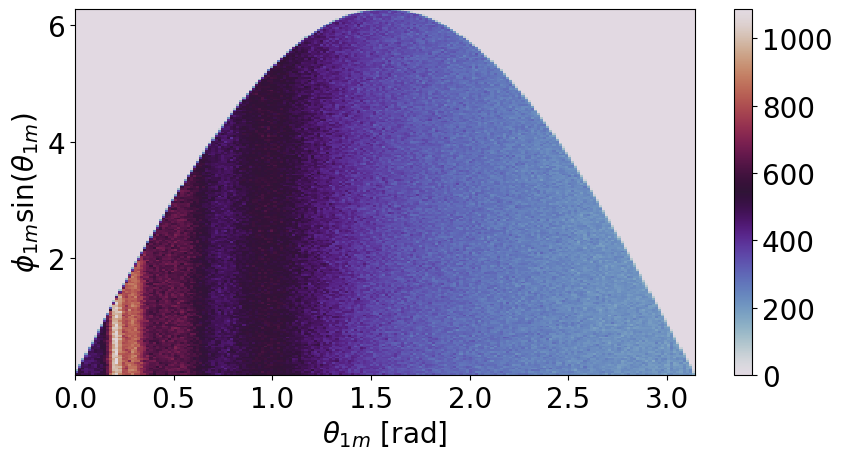

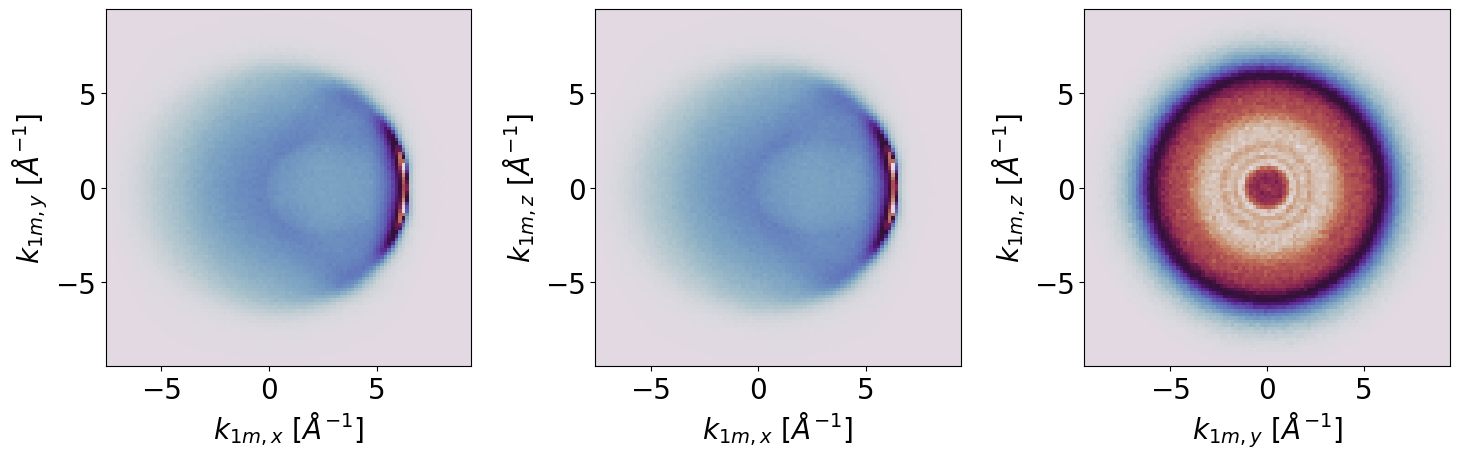

In [53]:
# plot
# heatmap
plt.figure(figsize=(9,5))
plt.hist2d(theta1m, phi1m*np.sin(theta1m), bins=200, cmap = 'twilight');
plt.xlabel(r'$\theta_{1m}$ [rad]')
plt.ylabel(r'$\phi_{1m} \sin(\theta_{1m})$')
plt.colorbar()
plt.xlim(0, np.pi)
plt.tight_layout()

plt.savefig('./figures4article/theta1m.png')

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.hist2d(k1m[:,0], k1m[:,1], bins=100, cmap = 'twilight');
plt.xlabel(r'$k_{1m,x}$ [$\AA^{-1}$]')
plt.ylabel(r'$k_{1m,y}$ [$\AA^{-1}$]')
plt.subplot(1,3,2)
plt.hist2d(k1m[:,0], k1m[:,2], bins=100, cmap = 'twilight');
plt.xlabel(r'$k_{1m,x}$ [$\AA^{-1}$]')
plt.ylabel(r'$k_{1m,z}$ [$\AA^{-1}$]')
plt.subplot(1,3,3)
plt.hist2d(k1m[:,1], k1m[:,2], bins=100, cmap = 'twilight');
plt.xlabel(r'$k_{1m,y}$ [$\AA^{-1}$]')
plt.ylabel(r'$k_{1m,z}$ [$\AA^{-1}$]')
plt.tight_layout()

plt.savefig('./figures4article/k1m.png')

### Extraction of the second scattering position
$$ w_{2m} = w_{1m} (1-T(d_{2m})) \frac{\mu_s}{\mu_{abs}}$$
and extraction from
$$ PDF_{L-B\  trunc} = e^{-\mu_{tot}x} \hspace{1cm} \text{with} \hspace{1cm} x = [0,d_{2m}] $$

In [39]:
##### 1m intercept calculation #####
ts = inter_fromin(p1, k1m)
ts = np.nan_to_num(ts)
if geom_type=='convex':
    ts = np.column_stack([ts, np.zeros((N,2))])
if geom_type=='concave':
    pass

d2m = ts[:,0] + (ts[:,2] - ts[:,1])
w2 = w1m*(1-T_tot(d2m))*mu_s/mu_tot

# position extraction
dtp2 = rand_LB(d2m)
void = np.where(dtp2<=ts[:, 0], 0,ts[:,1] - ts[:,0])
p2 = line_param(dtp2 + void, p1, k1m)

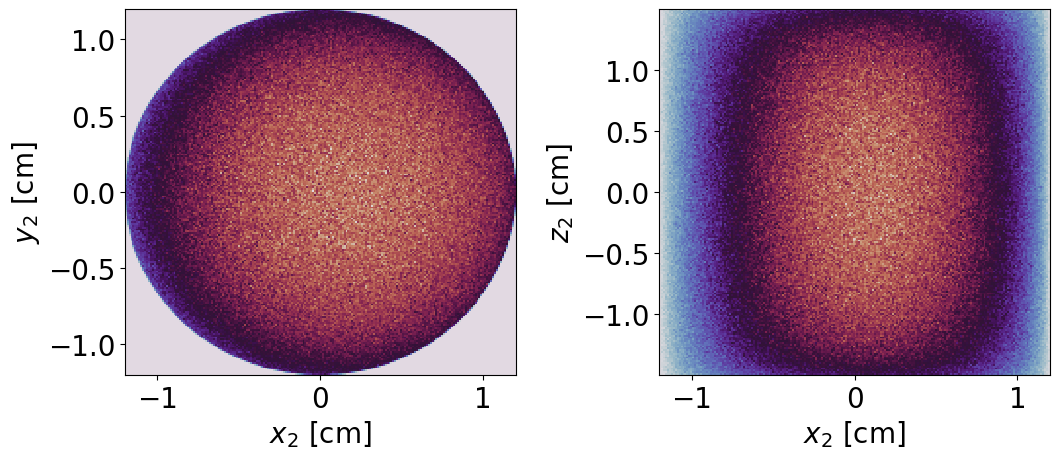

In [40]:
# plot
plt.figure(figsize=(11,5))
plt.subplot(1,2,1)
plt.hist2d(p2[:,0], p2[:,1], bins=200, weights=w2, cmap='twilight');
plt.xlabel(r'$x_2$ [cm]')
plt.ylabel(r'$y_2$ [cm]')
plt.subplot(1,2,2)
plt.hist2d(p2[:,0], p2[:,2], bins=200, weights=w2, cmap='twilight');
plt.xlabel(r'$x_2$ [cm]')
plt.ylabel(r'$z_2$ [cm]')
plt.tight_layout()

plt.savefig('./figures4article/p2.png')

### Probability of the 2 $^{nd}$ scattering event being detectable
We first find $k_{2m}$ and $\omega_{2m}$ imposing the collimator (detector) angle:
$$
\begin{array}{l}
    \textbf{k}_{2m} = k_f * (\cos(\theta), \sin(\theta), 0) \\
    \omega_{2m} = E_{1m} - E_f \\
\end{array}
$$
$$
\begin{array}{l}
    Q_{2m} = |\textbf{k}_{1m} - \textbf{k}_f| \\
    \theta_{2m} = \theta(k_{1m}, Q_{2m})
\end{array}
$$

In [41]:
##### Find k2m, omega2m, Q2m imposing collimator angle #####
k2m = kf * np.array([np.cos(theta), np.sin(theta), 0]) * np.ones((N, 3))
omega2m = (E1m - Ef) * np.ones(N)
Q2m = np.linalg.norm(k1m - k2m, axis=1)
theta2m = Q2theta(omega2m, E2k(E1m), Q2m)

MINOR CORRECTION: we should eliminate (mask) events outside of our $S(Q, \omega)$ mesh. This is later done by setting the weight to 0 if the event is outside the mesh.

In [42]:
### Mask of impossible events
M2mij = ~((Q2m>Qi.max()) | (Q2m<Qi.min()) | (omega2m>omegaj.max()) | (omega2m<omegaj.min()) | np.isnan(theta2m))

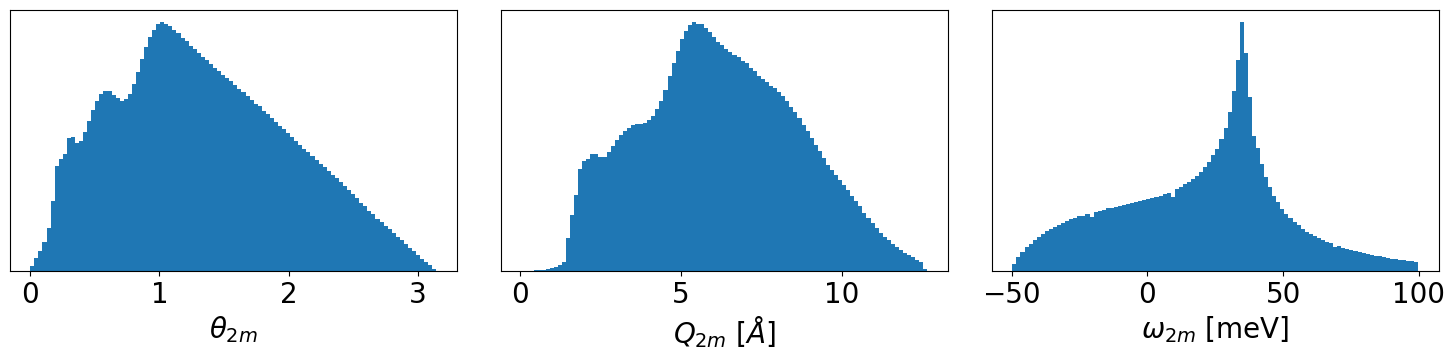

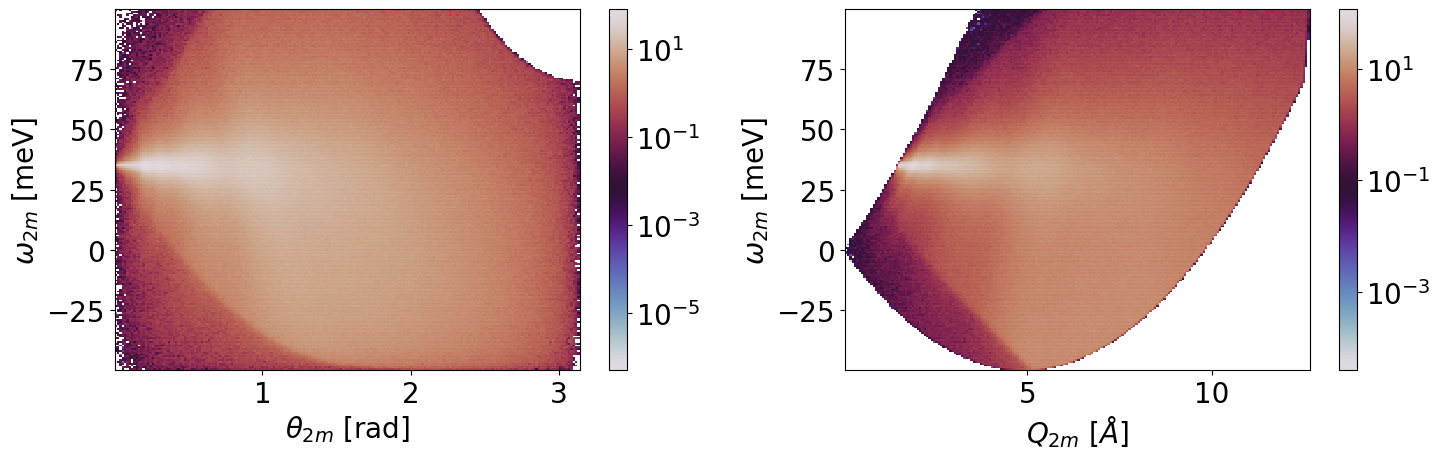

In [43]:
# plot
# 1D
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.hist(theta2m[M2mij], bins=100, density=True);
plt.yticks([])
plt.xlabel(r'$\theta_{2m}$')
plt.subplot(1,3,2)
plt.hist(Q2m[M2mij], bins=100, density=True);
plt.yticks([])
plt.xlabel(r'$Q_{2m}$ [$\AA$]')
plt.subplot(1,3,3)
plt.hist(omega2m[M2mij], bins=100, density=True);
plt.yticks([])
plt.xlabel(r'$\omega_{2m}$ [meV]')

plt.tight_layout()

# 2D
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist2d(theta2m[M2mij], omega2m[M2mij], bins=200, norm='log', weights=w2[M2mij], cmap='twilight');
plt.ylabel(r'$\omega_{2m}$ [meV]')
plt.xlabel(r'$\theta_{2m}$ [rad]')
plt.colorbar()

plt.subplot(1,2,2)
plt.hist2d(Q2m[M2mij], omega2m[M2mij], bins=200, norm='log', weights=w2[M2mij], cmap='twilight');
plt.ylabel(r'$\omega_{2m}$ [meV]')
plt.xlabel(r'$Q_{2m}$ [$\AA$]')
plt.tight_layout()
plt.colorbar()

Divide the energies $E_{1m}$ in $B$ bunches of width $dE = \text{max}(E_{1m})/B$. The approximated energy of the $l^{\text{th}}$ bunch is $E_l=dE*(l-\frac{1}{2})$. For each neutron in the bunch $l$, that is, for each neutron with $E_{1m}\in [E_l-dE/2, E_l+dE/2]$, the probability of being scattered towards the detector with the correct energy is
$$
    P^l(\theta_{2m}, \phi, \omega_{2m})  =  \frac{\sqrt{1-\frac{\omega_j}{E_i}}S^{k_l}_{i,j}}{\text{norm}} d\omega_{det} d\Omega_{det}
$$
with
$$
    \text{norm} \simeq 2\pi \sum_i^{N_Q} \sum_j^{N_\omega} \sqrt{1-\frac{\omega_j}{E_i}} S^{k_l}_{i,j} d\omega_j (\frac{d\theta}{dQ})_{i,j}^{k_l} dQ_{i} \sin\theta_{i,j}^{k_l}
$$

In [44]:
##### 2nd EVENT SCATTERING PROBABILITIES #####

# Bunching the initial energies E1m
E_min = E1m[M2mij].min()
E_max = E1m[M2mij].max()
E_ranges = np.linspace(E_min, E_max, B)[1:]
dbunch = (E_ranges[1]-E_ranges[0])

# find the bunch indexes
bunch_idx = np.searchsorted(E_ranges, E1m, side='left')
bunch_idx[~M2mij] = -1 # putting impossible events with idx=-1, i.e. in the next part P stay 0

# indexing Q2m and omega2m on the mesh
Q_idx = np.searchsorted(Qi, Q2m)
omega_idx = np.searchsorted(omegaj, omega2m)

# calculating probabilities at bunches
P = np.zeros(N)

for b in range(B-1):

    E_b = E_ranges[b]-dbunch/2
    k_b = E2k(E_b)

    Mij_b = ((Qij>Qlowlimi(k_b)) & (Qij<Quplimi(k_b)))
    Sij_b = Mij_b * Sij
    sinthetaij_b = np.nan_to_num(np.sin(Q2theta(omegaij, k_b, Qij)))
    dthetadqij_b = np.nan_to_num(dthetadq(omegaij, k_b, Qij)) * Mij_b
    
    norm = 2*np.pi*np.sum(np.nan_to_num(np.sqrt(1 - omegaij/E_b))*Sij_b * domegaj * dthetadqij_b * dQi * sinthetaij_b)

    i = Q_idx[bunch_idx==b]
    j = omega_idx[bunch_idx==b]
    ij = Q_idx[bunch_idx==b], omega_idx[bunch_idx==b]

    P[bunch_idx==b] = np.nan_to_num(np.sqrt(1 - omegaij[ij]/E_b))*Sij_b[ij]/norm * domega_det * dOmega_det

w2m = w2 * P

### Trasmission of second event to the detector
$$ w_{fm} = w_{2m} T(d_{3m}) $$


In [45]:
##### LAST INTERCEPT TRASMISSION #####
ts = inter_fromin(p1, k2m)
ts = np.nan_to_num(ts)
if geom_type=='convex':
    ts = np.column_stack([ts, np.zeros((N,2))])
if geom_type=='concave':
    pass

d3m = ts[:,0] + (ts[:,2] - ts[:,1])
wfm = w2m*T_tot(d3m)

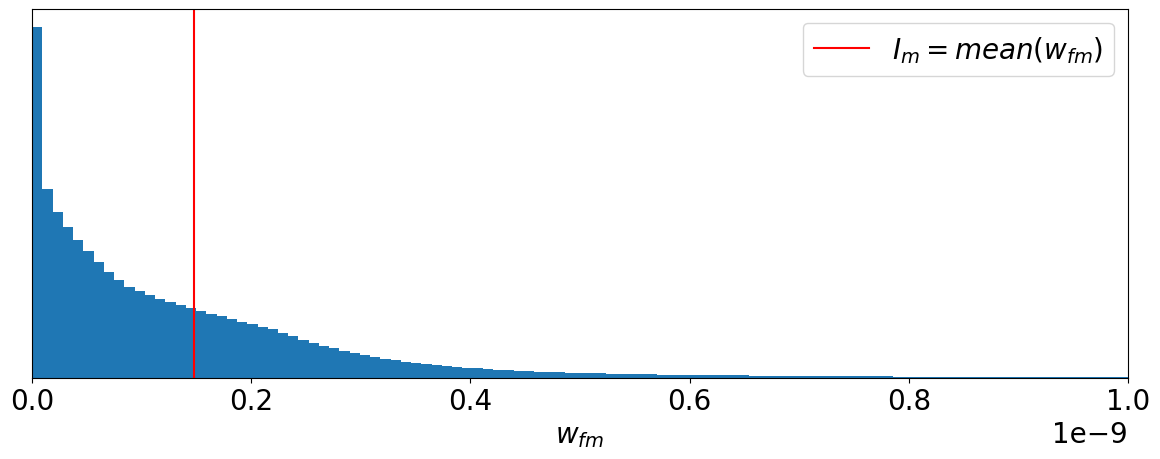

In [65]:
# plot
plt.figure(figsize=(12,5))
plt.hist(wfm, bins=3000);
plt.yticks([])
plt.axvline(Im, c='r', label=r'$I_m = mean(w_{fm}$)')
plt.xlabel(r'$w_{fm}$')
plt.legend()
plt.xlim(0,1e-9)
plt.tight_layout()

plt.savefig('./figures4article/wfm.png')

and
$$ I_m = \frac{1}{N} \sum_{i=1}^{N} w_{fm} $$

In [46]:
Im = wfm.mean()

print('Im : {:0.2e}'.format(Im))
print('Im/Is = {:0.2f}'.format(Im/Is))

Im : 1.48e-10
Im/Is = 0.53


## Let's see what happend

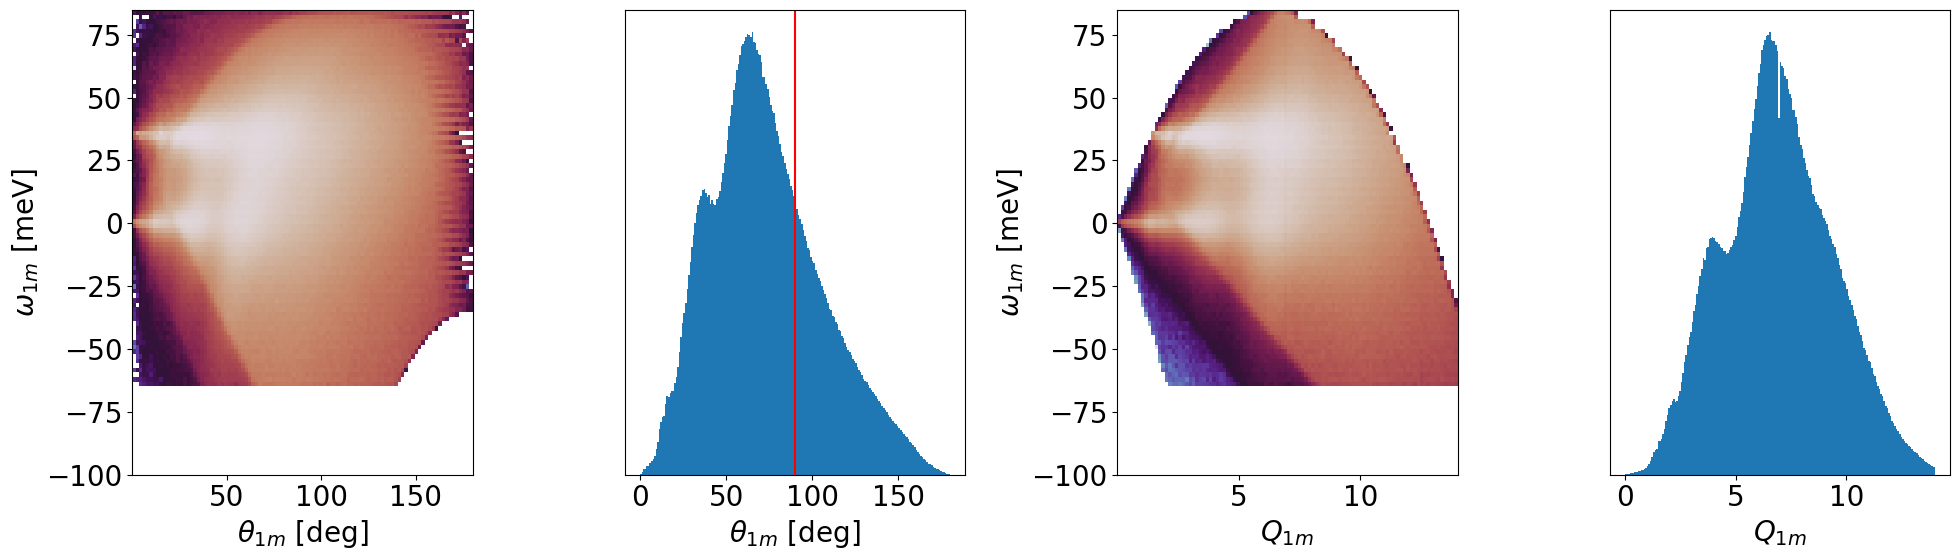

In [47]:
# heatmap
plt.figure(figsize=(20,6))
plt.subplot(1,4,1)
plt.hist2d(np.rad2deg(theta1m), omega1m, bins=100, weights=wfm, norm='log',  cmap='twilight');
plt.xlabel(r'$\theta_{1m}$ [deg]')
plt.ylabel('$\omega_{1m}$ [meV]')

plt.subplot(1,4,2)
plt.hist(np.rad2deg(theta1m), bins=200, weights=wfm);
plt.yticks([])
plt.axvline(90, c='r')
plt.xlabel(r'$\theta_{1m}$ [deg]')

plt.subplot(1,4,3)
plt.hist2d(Q1m, omega1m, bins=100, weights=wfm, norm='log',  cmap='twilight');
plt.xlabel(r'$Q_{1m}$')
plt.ylabel('$\omega_{1m}$ [meV]')

plt.subplot(1,4,4)
plt.hist(Q1m, bins=200, weights=wfm);
plt.yticks([]) 
plt.xlabel(r'$Q_{1m}$')

plt.tight_layout()

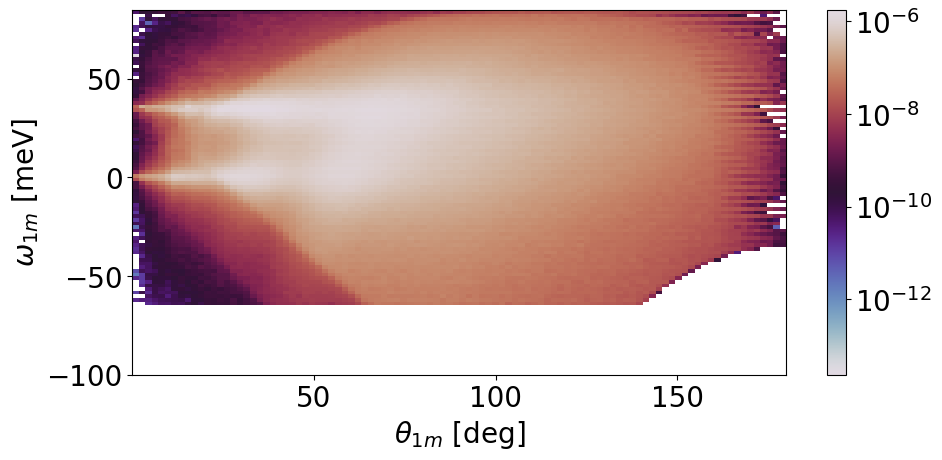

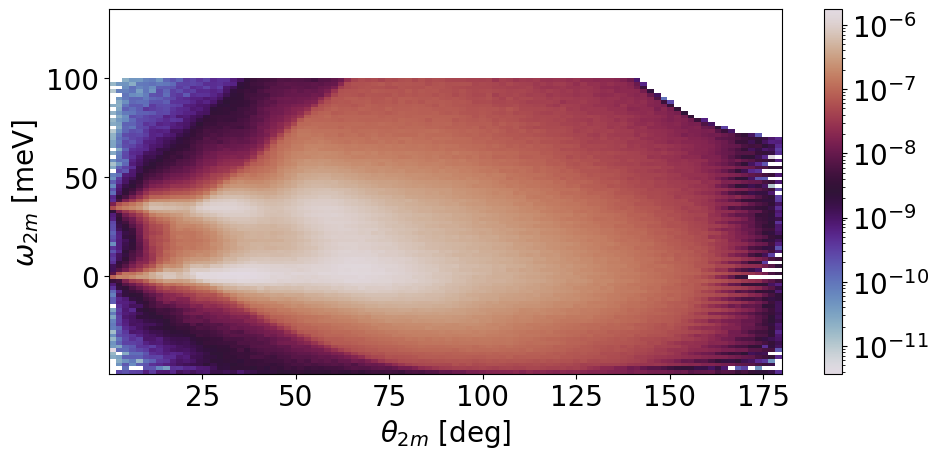

In [48]:
# heatmap
plt.figure(figsize=(10,5))
plt.hist2d(np.rad2deg(theta1m), omega1m, bins=100, weights=wfm, norm='log', cmap='twilight');
plt.xlabel(r'$\theta_{1m}$ [deg]')
plt.ylabel('$\omega_{1m}$ [meV]')
plt.tight_layout()
#plt.ylim(-60, 80)
plt.colorbar()

# heatmap
plt.figure(figsize=(10,5))
plt.hist2d(np.rad2deg(theta2m), omega2m, bins=100, weights=wfm, norm='log', cmap='twilight');
plt.xlabel(r'$\theta_{2m}$ [deg]')
plt.ylabel('$\omega_{2m}$ [meV]')
plt.tight_layout()
#plt.ylim(-60, 80)
plt.colorbar()


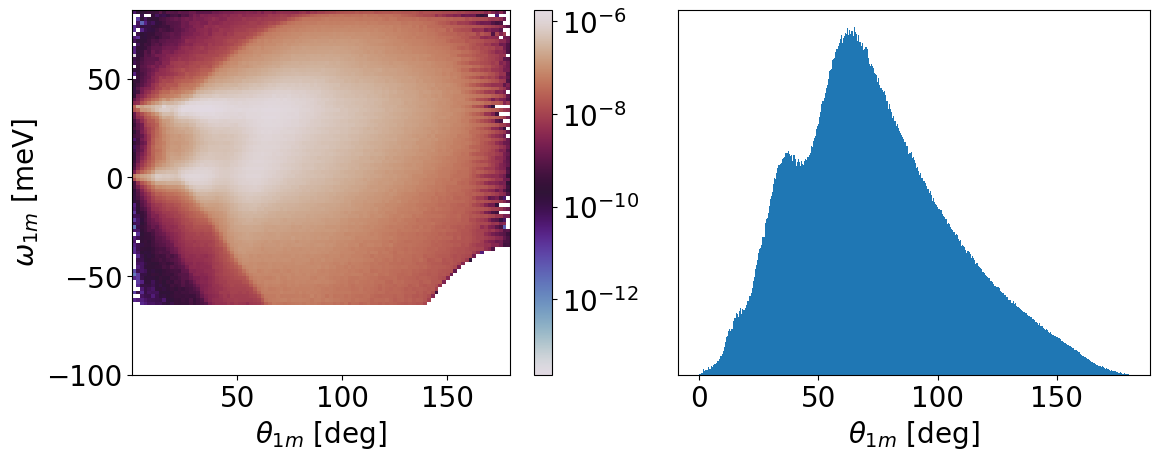

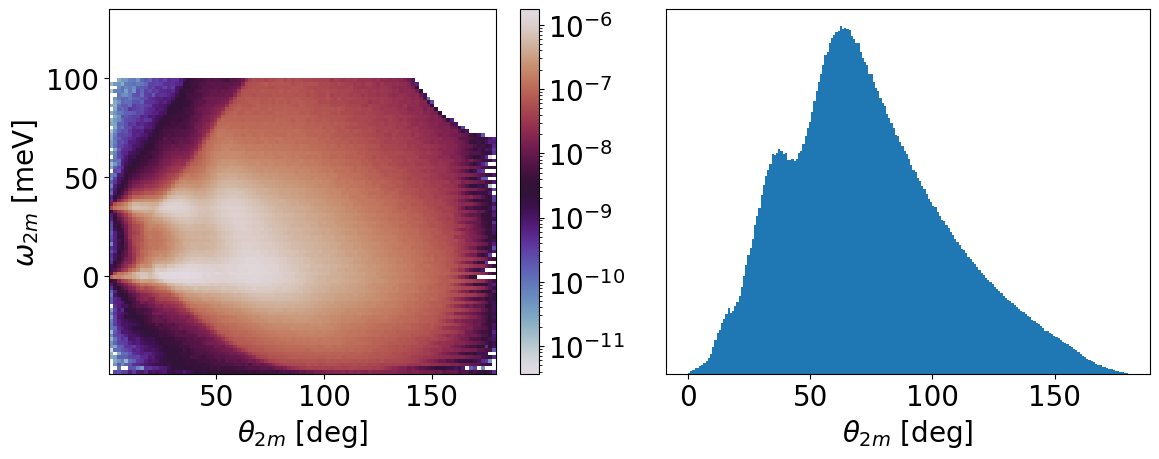

In [66]:
# heatmap
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist2d(np.rad2deg(theta1m), omega1m, bins=100, weights=wfm, norm='log', cmap='twilight');
plt.xlabel(r'$\theta_{1m}$ [deg]')
plt.ylabel('$\omega_{1m}$ [meV]')

plt.subplot(1,2,2)
plt.hist(np.rad2deg(theta1m), bins=400, weights=wfm);
#plt.axvline(90, c='r')
plt.xlabel(r'$\theta_{1m}$ [deg]')
plt.yticks([])
plt.colorbar()
plt.tight_layout()

plt.savefig('./figures4article/theta1m_omega1m_final.png')

# heatmap
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist2d(np.rad2deg(theta2m), omega2m, bins=100, weights=wfm, norm='log', cmap='twilight');
plt.colorbar()
plt.xlabel(r'$\theta_{2m}$ [deg]')
plt.ylabel('$\omega_{2m}$ [meV]')

plt.subplot(1,2,2)
plt.hist(np.rad2deg(theta2m), bins=200, weights=wfm);
#plt.axvline(90, c='r')
plt.xlabel(r'$\theta_{2m}$ [deg]')
plt.yticks([])
plt.tight_layout()

plt.savefig('./figures4article/theta2m_omega2m_final.png')